hackathon source = https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/

## Problem Statement
### About Company
Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.

### Problem
Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

## Data

**Variable**         |**Description**
:--------------------|:------------------------
Loan_ID              |Unique Loan ID
Gender               |Male/ Female
Married              |Applicant married (Y/N)
Dependents           |Number of dependents
Education            |Applicant Education (Graduate/ Under Graduate)
Self_Employed        |Self employed (Y/N)
ApplicantIncome      |Applicant income
CoapplicantIncome    |Coapplicant income
LoanAmount           |Loan amount in thousands
Loan_Amount_Term     |Term of loan in months
Credit_History       |Credit history meets guidelines
Property_Area        |Urban/ Semi Urban/ Rural
Loan_Status          |Loan approved (Y/N)
 

**Note:**

Evaluation Metric is accuracy i.e. percentage of loan approval you correctly predict.
You are expected to upload the solutionin a csv file with the following format:

Loan_ID | Loan_Status
:------:|:------------:
LP001002|1
LP001003|0
...     |...
LP001010|1

In [12]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import itertools
import csv
import zipfile

from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

from scipy import interp
from itertools import cycle

plt.style.use('ggplot')

Then, all you need to give is :

* The list of paths to your train datasets and test datasets
* The name of the target you try to predict (classification or regression)

In [34]:
# the list of paths to your train datasets and test datasets
train_data_path = "./data/train.csv"
test_data_path = "./data/test.csv"
paths = [train_data_path, test_data_path]

# the name of the target you try to predict (classification or regression)
target_name = "Loan_Status"

### Now, let the MLBox do the job !

... to read and preprocess your files :

In [46]:
# Reading
reader = Reader(sep=",")
data = reader.train_test_split(paths, target_name)


reading csv : train.csv ...
cleaning data...
CPU time: 0.09733867645263672 seconds

reading csv : test.csv ...
cleaning data...
CPU time: 0.06172466278076172 seconds

number of common features : 12

Gathering and crunching for train and test datasets
reindexing for train and test datasets
Dropping training duplicates
Dropping constant variables on training set

number of categorical features: 7
number of numerical features: 5
number of training samples : 614
number of test samples : 367

Top sparse features (% missing values on train set):
Credit_History      8.1
Self_Employed       5.2
LoanAmount          3.6
Dependents          2.4
Loan_Amount_Term    2.3
dtype: float64

task : classification
Y    422
N    192
Name: Loan_Status, dtype: int64
encoding target


In [47]:
# Deleting non-stable variables
dft = Drift_thresholder()
data = dft.fit_transform(data)


computing drifts...
CPU time: 0.5722939968109131 seconds

Top 10 drifts

('Loan_ID', 0.99837133550488599)
('Property_Area', 0.061928332571045575)
('Loan_Amount_Term', 0.054074882580603223)
('ApplicantIncome', 0.036496217969404832)
('Married', 0.027678590084996957)
('Dependents', 0.024188221609812377)
('LoanAmount', 0.023957261970819488)
('Education', 0.0222398896269278)
('Self_Employed', 0.02163707287702854)
('Credit_History', 0.013384582672619549)

deleted variables : ['Loan_ID']

dumping drift coefficients into directory : save
drift coefficients dumped


... to evaluate models (here default configuration)

In [43]:
opt = Optimiser(scoring='accuracy', n_folds=3)
opt.evaluate(None, data)

/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/mlbox/optimisation/optimiser.py:78: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


No parameters set. Default configuration is tested

##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> ESTIMATOR :{'silent': True, 'min_child_samples': 10, 'boosting_type': 'gbdt', 'n_estimators': 500, 'strategy': 'LightGBM', 'objective': 'binary', 'reg_lambda': 0, 'subsample_for_bin': 50000, 'nthread': -1, 'subsample_freq': 1, 'min_child_weight': 5, 'max_bin': 255, 'reg_alpha': 0, 'num_leaves': 31, 'min_split_gain': 0, 'max_depth': -1, 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'subsample': 0.9, 'seed': 0}


MEAN SCORE : accuracy = 0.786625219193
VARIANCE : 0.0104443613238 (fold 1 = 0.8, fold 2 = 0.785365853659, fold 3 = 0.774509803922)
CPU time: 0.6081538200378418 seconds



0.78662521919336836

... or to test and optimize the whole Pipeline [OPTIONAL]:

* missing data encoder, aka 'ne'
* categorical variables encoder, aka 'ce'
* feature selector, aka 'fs'
* meta-features stacker, aka 'stck'
* final estimator, aka 'est'

**NB :** please have a look at all the possibilities you have to configure the Pipeline (steps, parameters and values...)

In [58]:
space = {
    'ne__numerical_strategy':{
        "search": "choice",
        "space": ['mean','median', 0]
    },
    'ne__categorical_strategy':{
        "search": "choice",
        "space": [np.NaN, None]
    },
    'ce__strategy':{
        "search": "choice",
        "space": ['label_encoding','entity_embedding','random_projection', 'dummification']
    },
    'fs__strategy':{
        "search": "choice",
        "space": ['l1','variance','rf_feature_importance']
    },
    'fs__threshold':{
        "search":"uniform",
        "space":[0.01, 0.3]
    },
    'est__strategy' : {
        "search": "choice",
        "space" : ["XGBoost", "LightGBM"]
    },    
    'est__max_depth': {
        "search": "choice",
        "space": [3, 4, 5, 6, 7]
    },
    'est__learning_rate': {
        "search": "uniform",
        "space": [0.01, 0.1]
    },
    'est__subsample': {
        "search": "uniform",
        "space": [0.4, 0.9]
    },
    'est__reg_alpha': {
        "search":"uniform",
        "space": [0, 10]
    },
    'est__reg_lambda': {
        "search":"uniform",
        "space": [0, 10]
    },
    'est__n_estimators': {
        "search": "choice",
        "space": [500, 1000, 1250, 1500]
    }
}

best = opt.optimise(space, data, max_evals=40)


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': None}

>>> CA ENCODER :{'strategy': 'dummification'}

>>> FEATURE SELECTOR :{'threshold': 0.22713757311709015, 'strategy': 'rf_feature_importance'}

>>> ESTIMATOR :{'silent': True, 'min_child_samples': 10, 'boosting_type': 'gbdt', 'n_estimators': 500, 'subsample': 0.7447825107234776, 'objective': 'binary', 'reg_lambda': 2.541249402892196, 'subsample_for_bin': 50000, 'seed': 0, 'reg_alpha': 1.8658936341420629, 'nthread': -1, 'min_child_weight': 5, 'max_bin': 255, 'num_leaves': 31, 'min_split_gain': 0, 'max_depth': 3, 'colsample_bytree': 0.8, 'subsample_freq': 1, 'strategy': 'LightGBM', 'learning_rate': 0.025247749572769422}


MEAN SCORE : accuracy = -inf
VARIANCE : nan (fold 1 = -inf, fold 2 = -inf, fold 3 = -inf)
CPU time: 0.041673898696899414 seconds


#########################

/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/mlbox/optimisation/optimiser.py:429: UserWarning: An error occurred while computing the cross validation mean score. Check the parameter values and your scoring function.
  warnings.warn("An error occurred while computing the cross "
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/mlbox/optimisation/optimiser.py:429: UserWarning: An error occurred while computing the cross validation mean score. Check the parameter values and your scoring function.
  warnings.warn("An error occurred while computing the cross "
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/li


MEAN SCORE : accuracy = 0.809453212179
VARIANCE : 0.00361829698122 (fold 1 = 0.809756097561, fold 2 = 0.80487804878, fold 3 = 0.813725490196)
CPU time: 0.5282537937164307 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': nan}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'threshold': 0.09431270346977093, 'strategy': 'variance'}

>>> ESTIMATOR :{'silent': True, 'missing': None, 'n_estimators': 1250, 'seed': 0, 'objective': 'binary:logistic', 'reg_lambda': 3.8484490045833617, 'scale_pos_weight': 1, 'max_delta_step': 0, 'reg_alpha': 3.746262296919202, 'nthread': -1, 'min_child_weight': 1, 'base_score': 0.5, 'max_depth': 3, 'colsample_bylevel': 1.0, 'gamma': 0, 'colsample_bytree': 0.8, 'learning_rate': 0.05817750270255482, 'strategy': 'XGBoost', 'subsample': 0.7161048279209402}



/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/mlbox/optimisation/optimiser.py:429: UserWarning: An error occurred while computing the cross validation mean score. Check the parameter values and your scoring function.
  warnings.warn("An error occurred while computing the cross "
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/mlbox/optimisation/optimiser.py:429: UserWarning: An error occurred while computing the cross validation mean score. Check the parameter values and your scoring function.
  warnings.warn("An error occurred while computing the cross "
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/mlbox/optimisation/optimiser.py:429: UserWarning: An error occurred while computing the cross validation mean score. Check the parameter values and your scoring function.
  warnings.warn("An error occurred while computing the cross "
/home/jose.lopez/workspace/python_virtua


MEAN SCORE : accuracy = -inf
VARIANCE : nan (fold 1 = -inf, fold 2 = -inf, fold 3 = -inf)
CPU time: 0.7020859718322754 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': None}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'threshold': 0.24593036277589123, 'strategy': 'variance'}

>>> ESTIMATOR :{'silent': True, 'missing': None, 'n_estimators': 500, 'seed': 0, 'objective': 'binary:logistic', 'reg_lambda': 4.4147371649168505, 'scale_pos_weight': 1, 'max_delta_step': 0, 'reg_alpha': 1.6964416776846547, 'nthread': -1, 'min_child_weight': 1, 'base_score': 0.5, 'max_depth': 6, 'colsample_bylevel': 1.0, 'gamma': 0, 'colsample_bytree': 0.8, 'learning_rate': 0.05508401290894584, 'strategy': 'XGBoost', 'subsample': 0.6151477349242029}


MEAN SCORE : accuracy = -inf
VARIANCE : nan (fold 1 = -inf, fold 

/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/mlbox/optimisation/optimiser.py:429: UserWarning: An error occurred while computing the cross validation mean score. Check the parameter values and your scoring function.
  warnings.warn("An error occurred while computing the cross "
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/mlbox/optimisation/optimiser.py:429: UserWarning: An error occurred while computing the cross validation mean score. Check the parameter values and your scoring function.
  warnings.warn("An error occurred while computing the cross "
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/mlbox/optimisation/optimiser.py:429: UserWarning: An error occurred while computing the cross validation mean score. Check the parameter values and your scoring function.
  warnings.warn("An error occurred while computing the cross "




>>> ESTIMATOR :{'silent': True, 'min_child_samples': 10, 'boosting_type': 'gbdt', 'n_estimators': 1000, 'subsample': 0.8831816687153338, 'objective': 'binary', 'reg_lambda': 3.02919549915298, 'subsample_for_bin': 50000, 'seed': 0, 'reg_alpha': 1.0859565330130216, 'nthread': -1, 'min_child_weight': 5, 'max_bin': 255, 'num_leaves': 31, 'min_split_gain': 0, 'max_depth': 3, 'colsample_bytree': 0.8, 'subsample_freq': 1, 'strategy': 'LightGBM', 'learning_rate': 0.094740942268695}


MEAN SCORE : accuracy = 0.723051171688
VARIANCE : 0.0338870133013 (fold 1 = 0.756097560976, fold 2 = 0.736585365854, fold 3 = 0.676470588235)
CPU time: 1.1261484622955322 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': None}

>>> CA ENCODER :{'strategy': 'dummification'}

>>> FEATURE SELECTOR :{'threshold': 0.20899063104363372, 'strategy': 'l1'}

>>>

/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/mlbox/optimisation/optimiser.py:429: UserWarning: An error occurred while computing the cross validation mean score. Check the parameter values and your scoring function.
  warnings.warn("An error occurred while computing the cross "
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/mlbox/optimisation/optimiser.py:429: UserWarning: An error occurred while computing the cross validation mean score. Check the parameter values and your scoring function.
  warnings.warn("An error occurred while computing the cross "
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/mlbox/optimisation/optimiser.py:429: UserWarning: An error occurred while computing the cross validation mean score. Check the parameter values and your scoring function.
  warnings.warn("An error occurred while computing the cross "
/home/jose.lopez/workspace/python_virtua


MEAN SCORE : accuracy = 0.809453212179
VARIANCE : 0.00361829698122 (fold 1 = 0.809756097561, fold 2 = 0.80487804878, fold 3 = 0.813725490196)
CPU time: 0.820019006729126 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': nan}

>>> CA ENCODER :{'strategy': 'dummification'}

>>> FEATURE SELECTOR :{'threshold': 0.21680296303793548, 'strategy': 'rf_feature_importance'}

>>> ESTIMATOR :{'silent': True, 'missing': None, 'n_estimators': 1000, 'seed': 0, 'objective': 'binary:logistic', 'reg_lambda': 9.685892387270979, 'scale_pos_weight': 1, 'max_delta_step': 0, 'reg_alpha': 3.8790664347345927, 'nthread': -1, 'min_child_weight': 1, 'base_score': 0.5, 'max_depth': 5, 'colsample_bylevel': 1.0, 'gamma': 0, 'colsample_bytree': 0.8, 'learning_rate': 0.08754207159528556, 'strategy': 'XGBoost', 'subsample': 0.5431372577754134}


MEAN SCORE :

/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/mlbox/optimisation/optimiser.py:429: UserWarning: An error occurred while computing the cross validation mean score. Check the parameter values and your scoring function.
  warnings.warn("An error occurred while computing the cross "



MEAN SCORE : accuracy = 0.561485732504
VARIANCE : 0.175204265723 (fold 1 = 0.682926829268, fold 2 = 0.687804878049, fold 3 = 0.313725490196)
CPU time: 0.928257942199707 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': None}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'threshold': 0.05203350316620132, 'strategy': 'rf_feature_importance'}

>>> ESTIMATOR :{'silent': True, 'min_child_samples': 10, 'boosting_type': 'gbdt', 'n_estimators': 500, 'subsample': 0.5814294955352006, 'objective': 'binary', 'reg_lambda': 4.625659533838981, 'subsample_for_bin': 50000, 'seed': 0, 'reg_alpha': 8.290747273892318, 'nthread': -1, 'min_child_weight': 5, 'max_bin': 255, 'num_leaves': 31, 'min_split_gain': 0, 'max_depth': 7, 'colsample_bytree': 0.8, 'subsample_freq': 1, 'strategy': 'LightGBM', 'learning_rate': 0.0772

/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/mlbox/optimisation/optimiser.py:429: UserWarning: An error occurred while computing the cross validation mean score. Check the parameter values and your scoring function.
  warnings.warn("An error occurred while computing the cross "
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/mlbox/optimisation/optimiser.py:429: UserWarning: An error occurred while computing the cross validation mean score. Check the parameter values and your scoring function.
  warnings.warn("An error occurred while computing the cross "
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/li


MEAN SCORE : accuracy = 0.809453212179
VARIANCE : 0.00361829698122 (fold 1 = 0.809756097561, fold 2 = 0.80487804878, fold 3 = 0.813725490196)
CPU time: 0.9352493286132812 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': nan}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'threshold': 0.018395877571473748, 'strategy': 'l1'}

>>> ESTIMATOR :{'silent': True, 'min_child_samples': 10, 'boosting_type': 'gbdt', 'n_estimators': 1250, 'subsample': 0.8901058750346933, 'objective': 'binary', 'reg_lambda': 0.35701305062436184, 'subsample_for_bin': 50000, 'seed': 0, 'reg_alpha': 9.975070101654946, 'nthread': -1, 'min_child_weight': 5, 'max_bin': 255, 'num_leaves': 31, 'min_split_gain': 0, 'max_depth': 4, 'colsample_bytree': 0.8, 'subsample_freq': 1, 'strategy': 'LightGBM', 'learning_rate': 0.010149723500164

/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : accuracy = 0.809453212179
VARIANCE : 0.00361829698122 (fold 1 = 0.809756097561, fold 2 = 0.80487804878, fold 3 = 0.813725490196)
CPU time: 0.871588945388794 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': nan}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'threshold': 0.1151175597320497, 'strategy': 'l1'}

>>> ESTIMATOR :{'silent': True, 'min_child_samples': 10, 'boosting_type': 'gbdt', 'n_estimators': 1250, 'subsample': 0.6855610641414107, 'objective': 'binary', 'reg_lambda': 0.1569211464339545, 'subsample_for_bin': 50000, 'seed': 0, 'reg_alpha': 9.426294542975482, 'nthread': -1, 'min_child_weight': 5, 'max_bin': 255, 'num_leaves': 31, 'min_split_gain': 0, 'max_depth': 4, 'colsample_bytree': 0.8, 'subsample_freq': 1, 'strategy': 'LightGBM', 'learning_rate': 0.011195914300192941}

/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : accuracy = 0.809453212179
VARIANCE : 0.00361829698122 (fold 1 = 0.809756097561, fold 2 = 0.80487804878, fold 3 = 0.813725490196)
CPU time: 1.017467975616455 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': nan}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'threshold': 0.01885169797177598, 'strategy': 'l1'}

>>> ESTIMATOR :{'silent': True, 'min_child_samples': 10, 'boosting_type': 'gbdt', 'n_estimators': 1250, 'subsample': 0.8332183836018288, 'objective': 'binary', 'reg_lambda': 0.39284792370411736, 'subsample_for_bin': 50000, 'seed': 0, 'reg_alpha': 7.071557211287477, 'nthread': -1, 'min_child_weight': 5, 'max_bin': 255, 'num_leaves': 31, 'min_split_gain': 0, 'max_depth': 4, 'colsample_bytree': 0.8, 'subsample_freq': 1, 'strategy': 'LightGBM', 'learning_rate': 0.02374542618495393

/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : accuracy = 0.809453212179
VARIANCE : 0.00361829698122 (fold 1 = 0.809756097561, fold 2 = 0.80487804878, fold 3 = 0.813725490196)
CPU time: 0.5785212516784668 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': nan}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'threshold': 0.01154826922770112, 'strategy': 'l1'}

>>> ESTIMATOR :{'silent': True, 'min_child_samples': 10, 'boosting_type': 'gbdt', 'n_estimators': 1250, 'subsample': 0.8980175715175995, 'objective': 'binary', 'reg_lambda': 1.0580623860513585, 'subsample_for_bin': 50000, 'seed': 0, 'reg_alpha': 6.983296550763954, 'nthread': -1, 'min_child_weight': 5, 'max_bin': 255, 'num_leaves': 31, 'min_split_gain': 0, 'max_depth': 4, 'colsample_bytree': 0.8, 'subsample_freq': 1, 'strategy': 'LightGBM', 'learning_rate': 0.02953973001972777

/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'libline


MEAN SCORE : accuracy = 0.809453212179
VARIANCE : 0.00361829698122 (fold 1 = 0.809756097561, fold 2 = 0.80487804878, fold 3 = 0.813725490196)
CPU time: 0.4961879253387451 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': nan}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'threshold': 0.1189976904044587, 'strategy': 'l1'}

>>> ESTIMATOR :{'silent': True, 'min_child_samples': 10, 'boosting_type': 'gbdt', 'n_estimators': 1250, 'subsample': 0.6765514244791196, 'objective': 'binary', 'reg_lambda': 1.5511971997830027, 'subsample_for_bin': 50000, 'seed': 0, 'reg_alpha': 6.949680020807191, 'nthread': -1, 'min_child_weight': 5, 'max_bin': 255, 'num_leaves': 31, 'min_split_gain': 0, 'max_depth': 4, 'colsample_bytree': 0.8, 'subsample_freq': 1, 'strategy': 'LightGBM', 'learning_rate': 0.03329223222634376}

/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : accuracy = 0.809453212179
VARIANCE : 0.00361829698122 (fold 1 = 0.809756097561, fold 2 = 0.80487804878, fold 3 = 0.813725490196)
CPU time: 0.48798632621765137 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': nan}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'threshold': 0.036349940955998916, 'strategy': 'l1'}

>>> ESTIMATOR :{'silent': True, 'min_child_samples': 10, 'boosting_type': 'gbdt', 'n_estimators': 1250, 'subsample': 0.8380522422495096, 'objective': 'binary', 'reg_lambda': 1.4599262933571828, 'subsample_for_bin': 50000, 'seed': 0, 'reg_alpha': 4.704092239701621, 'nthread': -1, 'min_child_weight': 5, 'max_bin': 255, 'num_leaves': 31, 'min_split_gain': 0, 'max_depth': 4, 'colsample_bytree': 0.8, 'subsample_freq': 1, 'strategy': 'LightGBM', 'learning_rate': 0.035419393926141

/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'libline


MEAN SCORE : accuracy = 0.809453212179
VARIANCE : 0.00361829698122 (fold 1 = 0.809756097561, fold 2 = 0.80487804878, fold 3 = 0.813725490196)
CPU time: 0.49242353439331055 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': nan}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'threshold': 0.03243463144362711, 'strategy': 'l1'}

>>> ESTIMATOR :{'silent': True, 'min_child_samples': 10, 'boosting_type': 'gbdt', 'n_estimators': 1250, 'subsample': 0.8977344773989029, 'objective': 'binary', 'reg_lambda': 1.1732421285350587, 'subsample_for_bin': 50000, 'seed': 0, 'reg_alpha': 4.940421388241644, 'nthread': -1, 'min_child_weight': 5, 'max_bin': 255, 'num_leaves': 31, 'min_split_gain': 0, 'max_depth': 4, 'colsample_bytree': 0.8, 'subsample_freq': 1, 'strategy': 'LightGBM', 'learning_rate': 0.0374144317936447

/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : accuracy = 0.809453212179
VARIANCE : 0.00361829698122 (fold 1 = 0.809756097561, fold 2 = 0.80487804878, fold 3 = 0.813725490196)
CPU time: 0.5088114738464355 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': nan}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'threshold': 0.12631716727910347, 'strategy': 'l1'}

>>> ESTIMATOR :{'silent': True, 'min_child_samples': 10, 'boosting_type': 'gbdt', 'n_estimators': 1250, 'subsample': 0.403232860841443, 'objective': 'binary', 'reg_lambda': 7.8922977397815135, 'subsample_for_bin': 50000, 'seed': 0, 'reg_alpha': 4.76811074949344, 'nthread': -1, 'min_child_weight': 5, 'max_bin': 255, 'num_leaves': 31, 'min_split_gain': 0, 'max_depth': 4, 'colsample_bytree': 0.8, 'subsample_freq': 1, 'strategy': 'LightGBM', 'learning_rate': 0.0210601227466705

/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : accuracy = 0.809453212179
VARIANCE : 0.00361829698122 (fold 1 = 0.809756097561, fold 2 = 0.80487804878, fold 3 = 0.813725490196)
CPU time: 0.5377988815307617 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': nan}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'threshold': 0.17948645851284487, 'strategy': 'l1'}

>>> ESTIMATOR :{'silent': True, 'min_child_samples': 10, 'boosting_type': 'gbdt', 'n_estimators': 1250, 'subsample': 0.7199740028558584, 'objective': 'binary', 'reg_lambda': 2.232235123733561, 'subsample_for_bin': 50000, 'seed': 0, 'reg_alpha': 2.766252548611436, 'nthread': -1, 'min_child_weight': 5, 'max_bin': 255, 'num_leaves': 31, 'min_split_gain': 0, 'max_depth': 7, 'colsample_bytree': 0.8, 'subsample_freq': 1, 'strategy': 'LightGBM', 'learning_rate': 0.018328234519326407

/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : accuracy = 0.807803283915
VARIANCE : 0.00652245168528 (fold 1 = 0.814634146341, fold 2 = 0.809756097561, fold 3 = 0.799019607843)
CPU time: 0.7882161140441895 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': nan}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'threshold': 0.18242524348094227, 'strategy': 'l1'}

>>> ESTIMATOR :{'silent': True, 'min_child_samples': 10, 'boosting_type': 'gbdt', 'n_estimators': 1250, 'subsample': 0.7954178390782518, 'objective': 'binary', 'reg_lambda': 5.366271906704962, 'subsample_for_bin': 50000, 'seed': 0, 'reg_alpha': 2.4743620885084026, 'nthread': -1, 'min_child_weight': 5, 'max_bin': 255, 'num_leaves': 31, 'min_split_gain': 0, 'max_depth': 7, 'colsample_bytree': 0.8, 'subsample_freq': 1, 'strategy': 'LightGBM', 'learning_rate': 0.0407097224573263

/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : accuracy = 0.79802327435
VARIANCE : 0.00969411496605 (fold 1 = 0.80487804878, fold 2 = 0.80487804878, fold 3 = 0.78431372549)
CPU time: 0.6610441207885742 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': nan}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'threshold': 0.08418402028917599, 'strategy': 'rf_feature_importance'}

>>> ESTIMATOR :{'silent': True, 'min_child_samples': 10, 'boosting_type': 'gbdt', 'n_estimators': 1000, 'subsample': 0.41150590942940024, 'objective': 'binary', 'reg_lambda': 8.20473717035336, 'subsample_for_bin': 50000, 'seed': 0, 'reg_alpha': 4.647037909640672, 'nthread': -1, 'min_child_weight': 5, 'max_bin': 255, 'num_leaves': 31, 'min_split_gain': 0, 'max_depth': 6, 'colsample_bytree': 0.8, 'subsample_freq': 1, 'strategy': 'LightGBM', 'learning_rate': 0

... finally to predict on the test set with the best parameters (or None for default configuration):


fitting the pipeline...
CPU time: 0.5700221061706543 seconds

dumping feature importances into directory : save


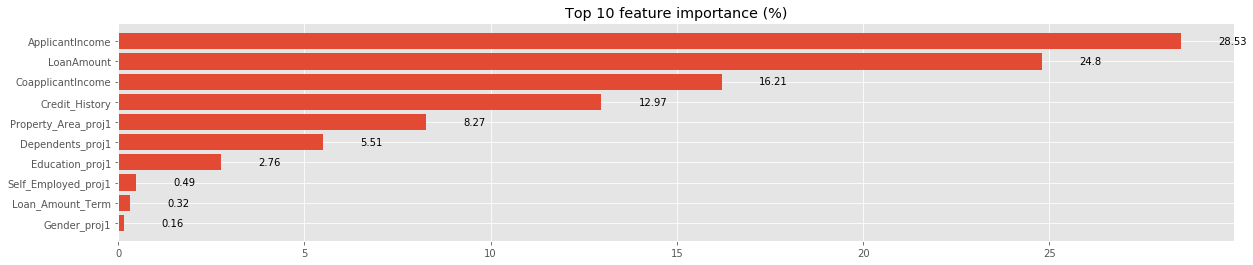


predicting...
CPU time: 0.0455470085144043 seconds

top 10 predictions :

          N         Y Loan_Status_predicted
0  0.179763  0.820237                     Y
1  0.099094  0.900906                     Y
2  0.202356  0.797644                     Y
3  0.169629  0.830371                     Y
4  0.339059  0.660941                     Y
5  0.236936  0.763064                     Y
6  0.241377  0.758623                     Y
7  0.878068  0.121932                     N
8  0.243784  0.756216                     Y
9  0.089693  0.910307                     Y

dumping predictions into directory : save


In [59]:
predictor = Predictor().fit_predict(best, data)

In [60]:
predictions_df = pd.read_csv(os.path.join(predictor.get_params()['to_path'], "{}_predictions.csv".format(target_name)))
predictions_df.columns = predictions_df.columns.str.replace('_predicted', '')

test_data = pd.read_csv(test_data_path)

solution_df = pd.DataFrame({
    'Loan_ID': test_data['Loan_ID'].values,
    target_name: predictions_df[target_name].values
})

def build_solution_file(filename, dataframe, tag=''):
    dataframe.to_csv(filename, index=False, quoting=csv.QUOTE_ALL)
    zipf = zipfile.ZipFile('submission_{}.zip'.format(tag), 'w', zipfile.ZIP_DEFLATED)
    zipf.write(filename)
    zipf.close()
    
timetag = format(pd.Timestamp.utcnow().tz_convert('Europe/Paris'), '%Y%m%d%H%M%S')
filename = "./result_{}.csv".format(timetag)

build_solution_file(filename, solution_df, tag=timetag)

score = 0.791667